# Figure 5
## Per Degree of Warming

In [3]:
import xarray
from distributed import Client, LocalCluster
import numpy as np
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


cluster = LocalCluster(
    n_workers=1,
    processes=True,
    dashboard_address=":8004",
    threads_per_worker=1,
    memory_limit="50GB"
)
client = Client(cluster)
cluster.scale(10)
client.wait_for_workers(10)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8004/status,
Dashboard: http://127.0.0.1:8004/status,Workers: 10
Total threads: 10,Total memory: 465.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43361,Workers: 10
Dashboard: http://127.0.0.1:8004/status,Total threads: 10
Started: Just now,Total memory: 465.66 GiB
Comm: tcp://127.0.0.1:45691,Total threads: 1
Dashboard: http://127.0.0.1:33353/status,Memory: 46.57 GiB
Nanny: tcp://127.0.0.1:42563,


In [5]:
pop_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/WorldPop/unconstrained/global_mosaic/1km/people_per_pixel/ppp_2020_1km_Aggregated.tif"
pop_ds_raw = xarray.open_dataset(pop_path)["band_data"].sel(band=1)

HW_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/HEAT_OUTPUTS/"
TEMP_DIR = "/projects/dgs/persad_research/SIMULATION_DATA/ZARR/LENS1/SIM_VARIABLES/"

land_mask_path = "/projects/dgs/persad_research/SIMULATION_DATA/DATA/LENS1/CESM1/all/001/day/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.200001-209912.nc"
land_mask = xarray.open_dataset(land_mask_path)["LANDFRAC"].mean(dim="time")

hw_mn_all = xarray.open_zarr(f"{HW_DIR}CESM1_LE_all_TREFHTMN_HW_METRICS.zarr")["HWF"]
hw_mn_xaer = xarray.open_zarr(f"{HW_DIR}CESM1_LE_xaer_TREFHTMN_HW_METRICS.zarr")["HWF"]
hw_mn_xghg = xarray.open_zarr(f"{HW_DIR}CESM1_LE_xghg_TREFHTMN_HW_METRICS.zarr")["HWF"]
hw_mn_pic = xarray.open_zarr(f"{HW_DIR}CESM1_LE_pic_TREFHTMN_HW_METRICS.zarr")["HWF"]

d_lat = hw_mn_all.lat.values[1] - hw_mn_all.lat.values[0]
lat_groups = np.arange(hw_mn_all.lat.values[0] - 0.5*d_lat, hw_mn_all.lat.values[-1] + 0.6*d_lat, d_lat)
d_lon = hw_mn_all.lon.values[1] - hw_mn_all.lon.values[0]
lon_groups = np.arange(hw_mn_all.lon.values[0] - 0.5*d_lon, hw_mn_all.lon.values[-1] + 0.6*d_lon, d_lon)
pop_ds_raw = pop_ds_raw.assign_coords(x=(pop_ds_raw.x.values % 360)).sortby("x")
pop_ds_resampled = pop_ds_raw.groupby_bins("y", lat_groups, labels=hw_mn_all.lat.values).sum().groupby_bins("x", lon_groups, labels=hw_mn_all.lon.values).sum()
pop_ds = pop_ds_resampled.rename({"y_bins":"lat", "x_bins":"lon"}).compute()

In [6]:
hw_mn_all_exposure_ts = hw_mn_all.weighted(pop_ds).mean(dim=["lat", "lon"]).compute()
hw_mn_xaer_exposure_ts = hw_mn_xaer.weighted(pop_ds).mean(dim=["lat", "lon"]).compute()
hw_mn_xghg_exposure_ts = hw_mn_xghg.weighted(pop_ds).mean(dim=["lat", "lon"]).compute()
hw_mn_pic_exposure_ts = hw_mn_pic.weighted(pop_ds).mean(dim=["lat", "lon"]).compute()

tmin_all = xarray.open_zarr(f"{TEMP_DIR}all_day_TREFHTMN.zarr")["TREFHTMN"].resample(time="YE").mean().where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()
tmin_xaer = xarray.open_zarr(f"{TEMP_DIR}xaer_day_TREFHTMN.zarr")["TREFHTMN"].resample(time="YE").mean().where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()
tmin_xghg = xarray.open_zarr(f"{TEMP_DIR}xghg_day_TREFHTMN.zarr")["TREFHTMN"].resample(time="YE").mean().where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()

pi_time_start = cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, has_year_zero=True)
pi_time_end = cftime.DatetimeNoLeap(2200, 12, 31, 0, 0, 0, 0, has_year_zero=True)
tmin_pic = xarray.open_zarr(f"{TEMP_DIR}preindustrial_day_TREFHTMN.zarr")["TREFHTMN"].sel(time=slice(pi_time_start, pi_time_end)).resample(time="YE").mean().where(land_mask > 0).weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()

/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 13.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 12.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.12/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 12.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [7]:
tmin_all = tmin_all.rename({"time": "year"}).assign_coords({"year": hw_mn_all_exposure_ts.year})
tmin_xaer = tmin_xaer.rename({"time": "year"}).assign_coords({"year": hw_mn_xaer_exposure_ts.year})
tmin_xghg = tmin_xghg.rename({"time": "year"}).assign_coords({"year": hw_mn_xghg_exposure_ts.year})
tmin_pic = tmin_pic.rename({"time": "year"}).assign_coords({"year": hw_mn_pic_exposure_ts.year})

Text(0, 0.5, 'Δ Heatwave Exposure Frequency (Δ Days per Year)')

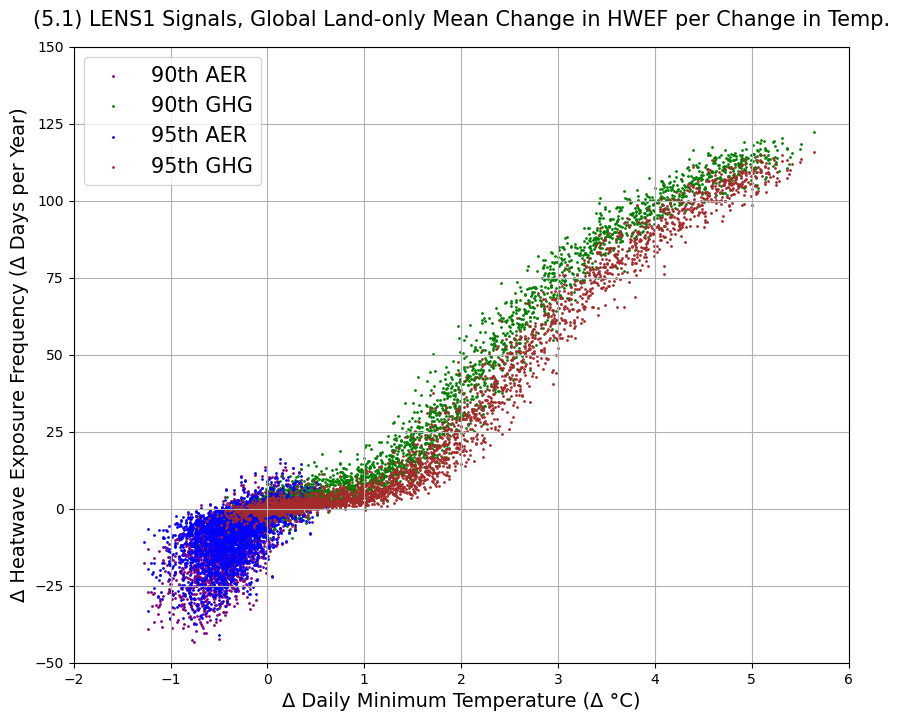

In [8]:
f_background_color = "#ffffff"
ax_background_color = "#ffffff"
grid_line_color = "#e8e8e8"
grid_line_lw = 0.8
all_color = "Black"
xaer_color = "Purple"
xghg_color = "Green"

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

# aer_ratio.mean(dim="member").plot(ax=ax1, color=xaer_color, linewidth=2, label="AER")
# ghg_ratio.mean(dim="member").plot(ax=ax1, color=xghg_color, linewidth=2, label="GHG")

hw_aer_90 = (hw_mn_all_exposure_ts - hw_mn_xaer_exposure_ts).sel(percentile=0.9, method="nearest")
hw_aer_95 = (hw_mn_all_exposure_ts - hw_mn_xaer_exposure_ts).sel(percentile=0.95, method="nearest")

hw_ghg_90 = (hw_mn_all_exposure_ts - hw_mn_xghg_exposure_ts).sel(percentile=0.9, method="nearest")
hw_ghg_95 = (hw_mn_all_exposure_ts - hw_mn_xghg_exposure_ts).sel(percentile=0.95, method="nearest")


s = 1
ax1.scatter((tmin_all - tmin_xaer).values.flatten(), hw_aer_90.values.flatten(), label="90th AER", s=s, color=xaer_color)
ax1.scatter((tmin_all - tmin_xghg).values.flatten(), hw_ghg_90.values.flatten(), label="90th GHG", s=s, color=xghg_color)

ax1.scatter((tmin_all - tmin_xaer).values.flatten(), hw_aer_95.values.flatten(), label="95th AER", s=s, color="Blue")
ax1.scatter((tmin_all - tmin_xghg).values.flatten(), hw_ghg_95.values.flatten(), label="95th GHG", s=s, color="Brown")

a = 0.3
# ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_aer_ts.min(dim="member"), hw_mn_aer_ts.max("member"), alpha=a, color=xaer_color)
# ax1.fill_between(hw_mn_aer_ts.year.values, hw_mn_ghg_ts.min(dim="member"), hw_mn_ghg_ts.max("member"), alpha=a, color=xghg_color)


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(-2, 6)
ax1.set_ylim(-50, 150)
ax1.set_title("(5.1) LENS1 Signals, Global Land-only Mean Change in HWEF per Change in Temp.", fontsize=15, pad=15)
ax1.set_xlabel("Δ Daily Minimum Temperature (Δ °C)", fontsize=14)
ax1.set_ylabel("Δ Heatwave Exposure Frequency (Δ Days per Year)", fontsize=14)

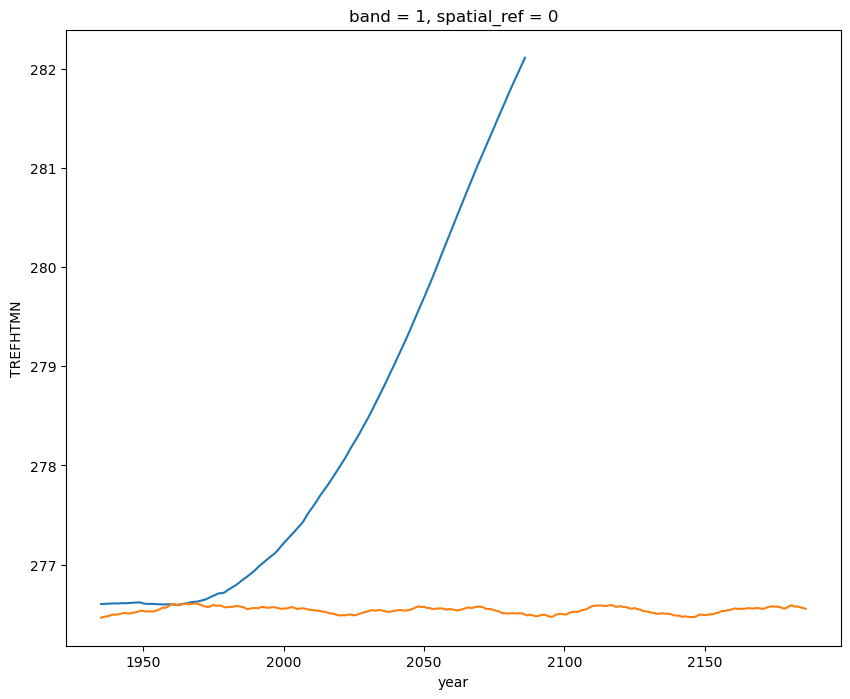

In [15]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')
all_tmin_ts.plot(ax=ax1)
pic_tmin_ts.plot(ax=ax1)

Text(0, 0.5, 'Δ HW Exp. Freq. per Δ Daily Min. Temp. (Δ Days / Δ °C)')

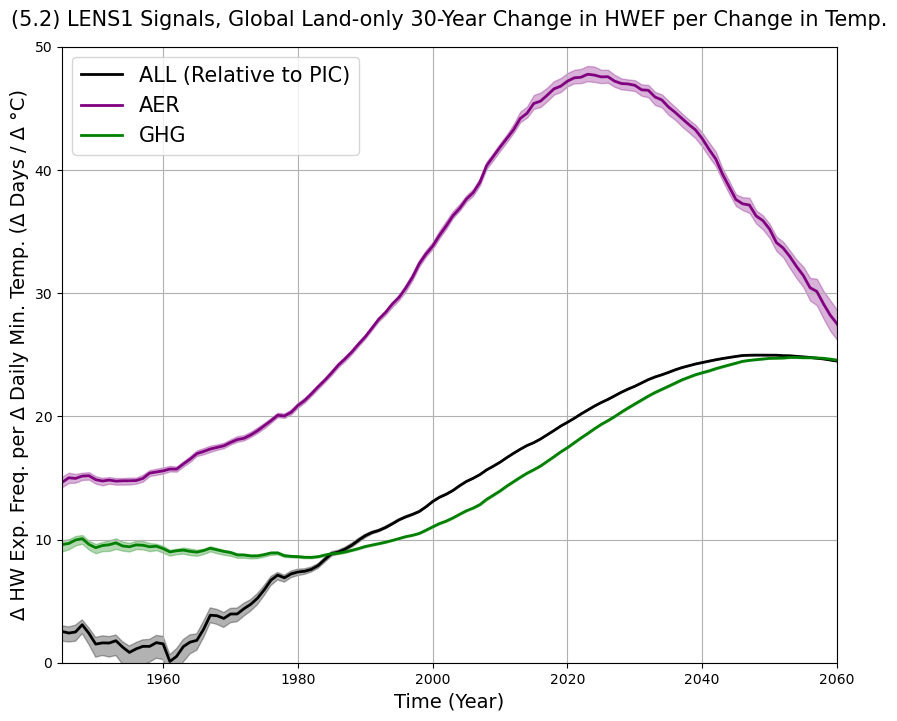

In [9]:
all_exp_ts = hw_mn_all_exposure_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xaer_exp_ts = hw_mn_xaer_exposure_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xghg_exp_ts = hw_mn_xghg_exposure_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
pic_exp_ts  = hw_mn_pic_exposure_ts.sel(percentile=0.9).rolling(year=30, center=True).mean()

all_tmin_ts = tmin_all.mean(dim="member").rolling(year=30, center=True).mean()
xaer_tmin_ts = tmin_xaer.mean(dim="member").rolling(year=30, center=True).mean()
xghg_tmin_ts = tmin_xghg.mean(dim="member").rolling(year=30, center=True).mean()
pic_tmin_ts = tmin_pic.rolling(year=30, center=True).mean()

all_ratio_avg = (all_exp_ts - pic_exp_ts.mean()) / (all_tmin_ts - pic_tmin_ts.mean())
aer_ratio_avg = (all_exp_ts - xaer_exp_ts) / (all_tmin_ts - xaer_tmin_ts)
ghg_ratio_avg = (all_exp_ts - xghg_exp_ts) / (all_tmin_ts - xghg_tmin_ts)

all_samples = []
aer_samples = []
ghg_samples = []
for index in range(hw_mn_all_exposure_ts.member.size):
    temp_labels = [label for label in tmin_xaer.member.values if not label == tmin_xaer.member.values[index]]
    hw_labels = [label for label in hw_mn_all_exposure_ts.member.values if not label == hw_mn_all_exposure_ts.member.values[index]]

    all_exp_ts = hw_mn_all_exposure_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    xaer_exp_ts = hw_mn_xaer_exposure_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    xghg_exp_ts = hw_mn_xghg_exposure_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    
    all_tmin_ts = tmin_all.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    xaer_tmin_ts = tmin_xaer.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    xghg_tmin_ts = tmin_xghg.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    
    all_ratio = (all_exp_ts - pic_exp_ts.mean()) / (all_tmin_ts - pic_tmin_ts.mean())
    aer_ratio = (all_exp_ts - xaer_exp_ts) / (all_tmin_ts - xaer_tmin_ts)
    ghg_ratio = (all_exp_ts - xghg_exp_ts) / (all_tmin_ts - xghg_tmin_ts)

    all_samples.append(all_ratio)
    aer_samples.append(aer_ratio)
    ghg_samples.append(ghg_ratio)

all_monte_carlo = xarray.concat(all_samples, dim="sample")
aer_monte_carlo = xarray.concat(aer_samples, dim="sample")
ghg_monte_carlo = xarray.concat(ghg_samples, dim="sample")

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

all_ratio_avg.plot(ax=ax1, color=all_color, label="ALL (Relative to PIC)", linewidth=2)
aer_ratio_avg.plot(ax=ax1, color=xaer_color, label="AER", linewidth=2)
ghg_ratio_avg.plot(ax=ax1, color=xghg_color, label="GHG", linewidth=2)

a = 0.3
ax1.fill_between(all_monte_carlo.year.values, all_monte_carlo.min(dim="sample"), all_monte_carlo.max(dim="sample"), alpha=a, color=all_color)
ax1.fill_between(aer_monte_carlo.year.values, aer_monte_carlo.min(dim="sample"), aer_monte_carlo.max(dim="sample"), alpha=a, color=xaer_color)
ax1.fill_between(ghg_monte_carlo.year.values, ghg_monte_carlo.min(dim="sample"), ghg_monte_carlo.max(dim="sample"), alpha=a, color=xghg_color)


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1945, 2060)
ax1.set_ylim(0, 50)
ax1.set_title("(5.2) LENS1 Signals, Global Land-only 30-Year Change in HWEF per Change in Temp.", fontsize=15, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ HW Exp. Freq. per Δ Daily Min. Temp. (Δ Days / Δ °C)", fontsize=14)

In [10]:
hw_mn_all_ts = hw_mn_all.weighted(np.cos(np.deg2rad(hw_mn_all.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xghg_ts = hw_mn_xghg.weighted(np.cos(np.deg2rad(hw_mn_xghg.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_xaer_ts = hw_mn_xaer.weighted(np.cos(np.deg2rad(hw_mn_xaer.lat))).mean(dim=["lat", "lon"]).compute()
hw_mn_pic_ts = hw_mn_pic.weighted(np.cos(np.deg2rad(hw_mn_pic.lat))).mean(dim=["lat", "lon"]).compute()

Text(0, 0.5, 'Δ HW Freq. per Δ Daily Min. Temp. (Δ Days / Δ °C)')

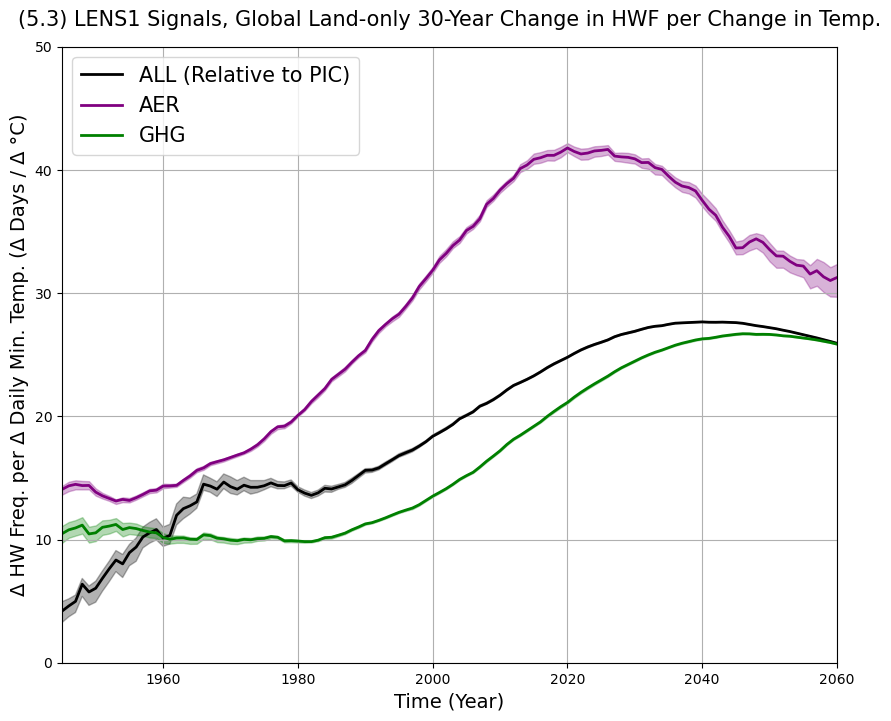

In [11]:
all_ts = hw_mn_all_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xaer_ts = hw_mn_xaer_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xghg_ts = hw_mn_xghg_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
pic_ts  = hw_mn_pic_ts.sel(percentile=0.9).rolling(year=30, center=True).mean()

all_tmin_ts = tmin_all.mean(dim="member").rolling(year=30, center=True).mean()
xaer_tmin_ts = tmin_xaer.mean(dim="member").rolling(year=30, center=True).mean()
xghg_tmin_ts = tmin_xghg.mean(dim="member").rolling(year=30, center=True).mean()
pic_tmin_ts = tmin_pic.rolling(year=30, center=True).mean()

all_ratio_avg = (all_ts - pic_ts.mean()) / (all_tmin_ts - pic_tmin_ts.mean())
aer_ratio_avg = (all_ts - xaer_ts) / (all_tmin_ts - xaer_tmin_ts)
ghg_ratio_avg = (all_ts - xghg_ts) / (all_tmin_ts - xghg_tmin_ts)

all_samples = []
aer_samples = []
ghg_samples = []
for index in range(hw_mn_all_ts.member.size):
    temp_labels = [label for label in tmin_xaer.member.values if not label == tmin_xaer.member.values[index]]
    hw_labels = [label for label in hw_mn_all_ts.member.values if not label == hw_mn_all_ts.member.values[index]]

    all_ts = hw_mn_all_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    xaer_ts = hw_mn_xaer_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    xghg_ts = hw_mn_xghg_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()

    all_tmin_ts = tmin_all.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    xaer_tmin_ts = tmin_xaer.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    xghg_tmin_ts = tmin_xghg.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    
    all_ratio = (all_ts - pic_ts.mean()) / (all_tmin_ts - pic_tmin_ts.mean())
    aer_ratio = (all_ts - xaer_ts) / (all_tmin_ts - xaer_tmin_ts)
    ghg_ratio = (all_ts - xghg_ts) / (all_tmin_ts - xghg_tmin_ts)

    all_samples.append(all_ratio)
    aer_samples.append(aer_ratio)
    ghg_samples.append(ghg_ratio)

all_monte_carlo = xarray.concat(all_samples, dim="sample")
aer_monte_carlo = xarray.concat(aer_samples, dim="sample")
ghg_monte_carlo = xarray.concat(ghg_samples, dim="sample")

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')

all_ratio_avg.plot(ax=ax1, color=all_color, label="ALL (Relative to PIC)", linewidth=2)
aer_ratio_avg.plot(ax=ax1, color=xaer_color, label="AER", linewidth=2)
ghg_ratio_avg.plot(ax=ax1, color=xghg_color, label="GHG", linewidth=2)

a = 0.3
ax1.fill_between(all_monte_carlo.year.values, all_monte_carlo.min(dim="sample"), all_monte_carlo.max(dim="sample"), alpha=a, color=all_color)
ax1.fill_between(aer_monte_carlo.year.values, aer_monte_carlo.min(dim="sample"), aer_monte_carlo.max(dim="sample"), alpha=a, color=xaer_color)
ax1.fill_between(ghg_monte_carlo.year.values, ghg_monte_carlo.min(dim="sample"), ghg_monte_carlo.max(dim="sample"), alpha=a, color=xghg_color)

ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1945, 2060)
ax1.set_ylim(0, 50)
ax1.set_title("(5.3) LENS1 Signals, Global Land-only 30-Year Change in HWF per Change in Temp.", fontsize=15, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ HW Freq. per Δ Daily Min. Temp. (Δ Days / Δ °C)", fontsize=14)

Text(0, 0.5, 'Δ HW (Exp.) Freq. per Δ Daily Min. Temp. (Δ Days / Δ °C)')

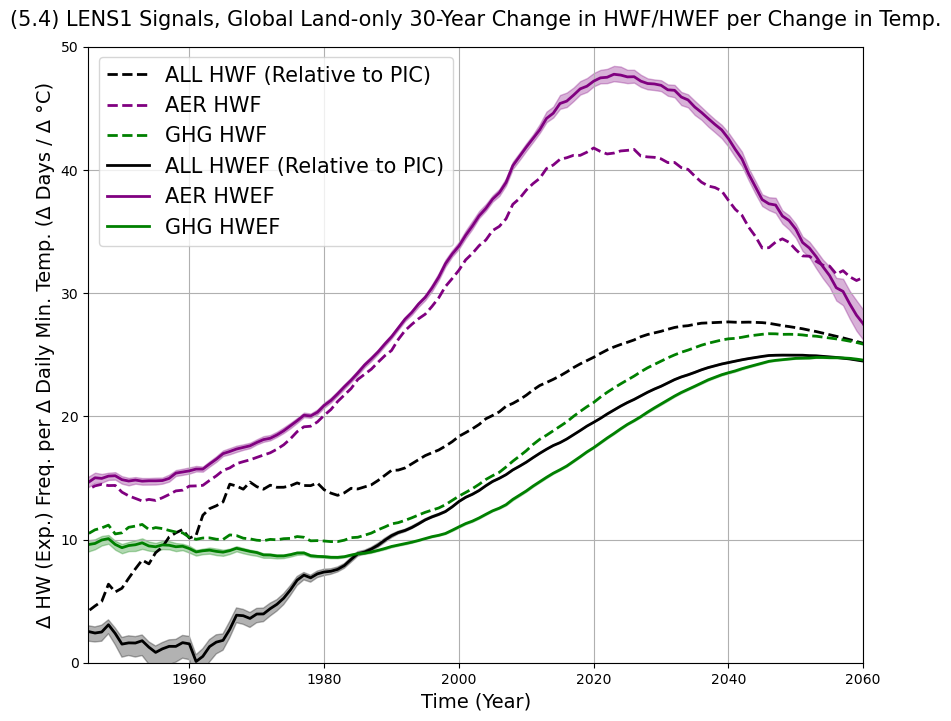

In [12]:
normal_ls = '--'

f, ax1 = plt.subplots(1, 1, figsize=(10, 8), facecolor='w')


all_ts = hw_mn_all_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xaer_ts = hw_mn_xaer_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xghg_ts = hw_mn_xghg_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
pic_ts  = hw_mn_pic_ts.sel(percentile=0.9).rolling(year=30, center=True).mean()

all_tmin_ts = tmin_all.mean(dim="member").rolling(year=30, center=True).mean()
xaer_tmin_ts = tmin_xaer.mean(dim="member").rolling(year=30, center=True).mean()
xghg_tmin_ts = tmin_xghg.mean(dim="member").rolling(year=30, center=True).mean()
pic_tmin_ts = tmin_pic.rolling(year=30, center=True).mean()

all_ratio_avg = (all_ts - pic_ts.mean()) / (all_tmin_ts - pic_tmin_ts.mean())
aer_ratio_avg = (all_ts - xaer_ts) / (all_tmin_ts - xaer_tmin_ts)
ghg_ratio_avg = (all_ts - xghg_ts) / (all_tmin_ts - xghg_tmin_ts)

all_ratio_avg.plot(ax=ax1, color=all_color, label="ALL HWF (Relative to PIC)", linewidth=2, linestyle=normal_ls)
aer_ratio_avg.plot(ax=ax1, color=xaer_color, label="AER HWF", linewidth=2, linestyle=normal_ls)
ghg_ratio_avg.plot(ax=ax1, color=xghg_color, label="GHG HWF", linewidth=2, linestyle=normal_ls)

all_exp_ts = hw_mn_all_exposure_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xaer_exp_ts = hw_mn_xaer_exposure_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
xghg_exp_ts = hw_mn_xghg_exposure_ts.mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
pic_exp_ts  = hw_mn_pic_exposure_ts.sel(percentile=0.9).rolling(year=30, center=True).mean()

all_tmin_ts = tmin_all.mean(dim="member").rolling(year=30, center=True).mean()
xaer_tmin_ts = tmin_xaer.mean(dim="member").rolling(year=30, center=True).mean()
xghg_tmin_ts = tmin_xghg.mean(dim="member").rolling(year=30, center=True).mean()
pic_tmin_ts = tmin_pic.rolling(year=30, center=True).mean()

all_exp_ratio_avg = (all_exp_ts - pic_exp_ts.mean()) / (all_tmin_ts - pic_tmin_ts.mean())
aer_exp_ratio_avg = (all_exp_ts - xaer_exp_ts) / (all_tmin_ts - xaer_tmin_ts)
ghg_exp_ratio_avg = (all_exp_ts - xghg_exp_ts) / (all_tmin_ts - xghg_tmin_ts)

all_exp_samples = []
aer_exp_samples = []
ghg_exp_samples = []
for index in range(hw_mn_all_exposure_ts.member.size):
    temp_labels = [label for label in tmin_xaer.member.values if not label == tmin_xaer.member.values[index]]
    hw_labels = [label for label in hw_mn_all_exposure_ts.member.values if not label == hw_mn_all_exposure_ts.member.values[index]]

    all_exp_ts = hw_mn_all_exposure_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    xaer_exp_ts = hw_mn_xaer_exposure_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    xghg_exp_ts = hw_mn_xghg_exposure_ts.sel(member=hw_labels, drop=True).mean(dim="member").sel(percentile=0.9).rolling(year=30, center=True).mean()
    
    all_tmin_ts = tmin_all.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    xaer_tmin_ts = tmin_xaer.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    xghg_tmin_ts = tmin_xghg.sel(member=temp_labels, drop=True).mean(dim="member").rolling(year=30, center=True).mean()
    
    all_ratio = (all_exp_ts - pic_exp_ts.mean()) / (all_tmin_ts - pic_tmin_ts.mean())
    aer_ratio = (all_exp_ts - xaer_exp_ts) / (all_tmin_ts - xaer_tmin_ts)
    ghg_ratio = (all_exp_ts - xghg_exp_ts) / (all_tmin_ts - xghg_tmin_ts)

    all_exp_samples.append(all_ratio)
    aer_exp_samples.append(aer_ratio)
    ghg_exp_samples.append(ghg_ratio)

all_exp_monte_carlo = xarray.concat(all_exp_samples, dim="sample")
aer_exp_monte_carlo = xarray.concat(aer_exp_samples, dim="sample")
ghg_exp_monte_carlo = xarray.concat(ghg_exp_samples, dim="sample")

all_exp_ratio_avg.plot(ax=ax1, color=all_color, label="ALL HWEF (Relative to PIC)", linewidth=2)
aer_exp_ratio_avg.plot(ax=ax1, color=xaer_color, label="AER HWEF", linewidth=2)
ghg_exp_ratio_avg.plot(ax=ax1, color=xghg_color, label="GHG HWEF", linewidth=2)

a = 0.3
ax1.fill_between(all_exp_monte_carlo.year.values, all_exp_monte_carlo.min(dim="sample"), all_exp_monte_carlo.max(dim="sample"), alpha=a, color=all_color)
ax1.fill_between(aer_exp_monte_carlo.year.values, aer_exp_monte_carlo.min(dim="sample"), aer_exp_monte_carlo.max(dim="sample"), alpha=a, color=xaer_color)
ax1.fill_between(ghg_exp_monte_carlo.year.values, ghg_exp_monte_carlo.min(dim="sample"), ghg_exp_monte_carlo.max(dim="sample"), alpha=a, color=xghg_color)


ax1.grid(zorder=-10)
ax1.legend(fontsize=15)
ax1.set_xlim(1945, 2060)
ax1.set_ylim(0, 50)
ax1.set_title("(5.4) LENS1 Signals, Global Land-only 30-Year Change in HWF/HWEF per Change in Temp.", fontsize=15, pad=15)
ax1.set_xlabel("Time (Year)", fontsize=14)
ax1.set_ylabel("Δ HW (Exp.) Freq. per Δ Daily Min. Temp. (Δ Days / Δ °C)", fontsize=14)

In [13]:
client.shutdown()